In [1]:
# ガウス過程回帰で使用
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# ハイパラ推定で使用
from scipy.optimize import minimize, fmin_l_bfgs_b
from paramz.optimization import SCG

# 実データの解析で使用
import pandas as pd

## ガウス過程回帰モデル

In [2]:
class MyGPR:
    def __init__(self, xtrain, ytrain, xx, kernel: str, params_init: list, xnormalize: bool = False, ynormalize: bool = False) -> None:
        self.xtrain_raw, self.ytrain_raw = xtrain, ytrain
        self.xx_raw = xx
        self.kernel_name = kernel
        self.params_init = params_init
        self.params_opt = None
        if xnormalize is True:
            self.xmean = np.mean(self.xtrain_raw)
            self.xstd = np.std(self.xtrain_raw)
            self.xtrain = (self.xtrain_raw - self.xmean)/self.xstd
            self.xx = (self.xx_raw - self.xmean)/self.xstd
        else:
            self.xmean = 0.0
            self.xstd = 1.0
            self.xtrain = self.xtrain_raw
            self.xx = self.xx_raw
        if ynormalize is True:
            self.ymean = np.mean(self.ytrain_raw)
            self.ystd = np.std(self.ytrain_raw)
            self.ytrain = (self.ytrain_raw - self.ymean)/self.ystd
        else:
            self.ymean = 0.0
            self.ystd = 1.0
            self.ytrain = self.ytrain_raw
        if self.kernel_name == "rbf":
            self.kernel = self.kgauss
        elif self.kernel_name == "original1":
            self.kernel = self.koriginal1
    
    def kgauss(self, params):
        tau, sigma, eta = params
        return lambda x1, x2, train=True: np.exp(tau) * np.exp(- np.sum((x1 - x2) ** 2, axis=0) / np.exp(sigma)) + (np.exp(eta) if (train and x1 == x2) else 0.0)

    def koriginal1(self, params):
        tau, sigma, eta, alpha, beta = params
        return lambda x1, x2, train=True: np.exp(alpha) + np.exp(beta)*np.dot(x1, x2) + np.exp(tau) * np.exp(- np.sum((x1 - x2) ** 2, axis=0) / np.exp(sigma)) + (np.exp(eta) if (train and x1 == x2) else 0.0)
    
    def kv(self, params, x):
        return np.array([self.kernel(params)(x, self.xtrain[i], False) for i in range(self.xtrain.shape[0])]).reshape(-1, 1)
    
    def kernel_matrix(self, params):
        n = self.xtrain.shape[0]
        K = np.array([self.kernel(params)(xi, xj) for xi in self.xtrain for xj in self.xtrain]).reshape(n, n)
        return K
    
    def gpr(self, params):
        K = self.kernel_matrix(params)
        K_inv = np.linalg.inv(K)
        ypr = np.zeros(self.xx.shape[0])
        spr = np.zeros(self.xx.shape[0])
        for i in range(self.xx.shape[0]):
            x = self.xx[i]
            s = self.kernel(params)(x, x)
            k = self.kv(params, x)
            ypr[i] = (k.T @ K_inv @ self.ytrain)[0,0]
            spr[i] = (s - k.T @ K_inv @ k)[0,0]
        return ypr, spr
    
    def rescale(self, yy, ss):
        return yy*self.ystd + self.ymean, ss*self.ystd**2
    
    def plot_gpr(self):
        if self.params_opt is None:
            params = self.params_init
        else:
            params = self.params_opt
        ypr, spr = self.gpr(params)
        ypr, spr = self.rescale(ypr, spr)
        fig, ax = plt.subplots()
        ax.plot(self.xx_raw[:, 0], ypr, label='Pred', color='blue')
        ax.fill_between(self.xx_raw[:, 0], ypr - 2*np.sqrt(spr), ypr + 2*np.sqrt(spr), color='#ccccff', label='2$\\sigma$')
        ax.scatter(self.xtrain_raw[:, 0], self.ytrain_raw, marker='x', color='black', label='Train')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.legend()
        plt.show()

In [3]:
data = np.loadtxt('./../data/chap3/gpr.dat')
xtrain, ytrain = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
xx = np.linspace(-1, 3.5, 100).reshape(-1, 1)

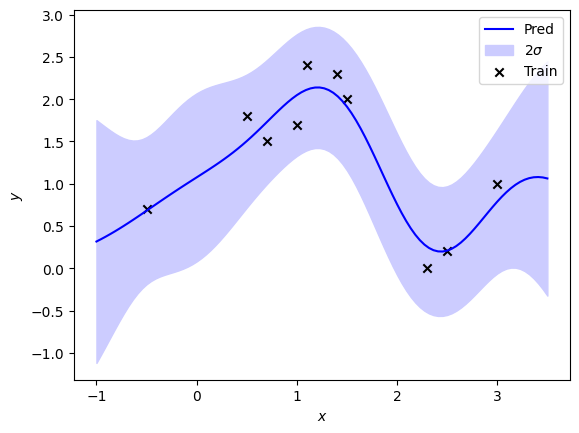

In [4]:
params = [np.log(1.0), np.log(1.0), np.log(0.1)]
mygpr = MyGPR(xtrain, ytrain, xx, "rbf", params)
ypr, spr = mygpr.gpr(params)
mygpr.plot_gpr()

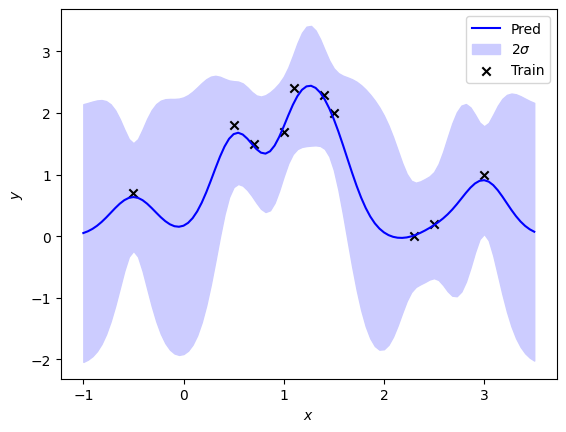

In [5]:
params = [np.log(1.0), np.log(0.1), np.log(0.1)]
mygpr = MyGPR(xtrain, ytrain, xx, "rbf", params)
ypr, spr = mygpr.gpr(params)
mygpr.plot_gpr()

## ガウス過程回帰のハイパーパラメータ推定

In [6]:
class MyGPR_opt(MyGPR):
    def __init__(self, xtrain, ytrain, xx, kernel: str, params_init: list, xnormalize: bool = False, ynormalize: bool = False) -> None:
        super().__init__(xtrain, ytrain, xx, kernel, params_init, xnormalize, ynormalize)
        if self.kernel_name == "rbf":
            self.kgrad = self.kgauss_grad
        elif self.kernel_name == "original1":
            self.kgrad = self.koriginal1_grad
    
    def logL(self, params):
        K = self.kernel_matrix(params)
        K_inv = np.linalg.inv(K)
        loglik = - np.log(np.abs(np.linalg.det(K))) - (self.ytrain.T @ K_inv @ self.ytrain)[0,0]
        return - loglik # 符号反転させて最小化問題に変換
    
    def gradient(self, params):
        K = self.kernel_matrix(params)
        K_inv = np.linalg.inv(K)
        d = len(params)
        n = self.xtrain.shape[0]
        grad = np.zeros(d)
        K_inv_y = K_inv @ self.ytrain
        for k in range(d):
            G = np.array([self.kgrad(params, xi, xj, k) for xi in self.xtrain for xj in self.xtrain]).reshape(n, n)
            grad[k] = - np.trace(K_inv @ G) + (K_inv_y.T @ G @ K_inv_y)[0,0]
        return - grad # 符号反転させて最小化問題に変換
    
    def kgauss_grad(self, params, x1, x2, d):
        tau, sigma, eta = params
        if d == 0:
            # return self.kgauss(params)(x1, x2)
            return self.kgauss(params)(x1, x2) - (np.exp(eta) if x1 == x2 else 0.0)
        elif d == 1:
            # return (self.kgauss(params)(x1, x2)) * np.sum((x1 - x2) ** 2, axis=0) / np.exp(sigma)
            return (self.kgauss(params)(x1, x2) - (np.exp(eta) if x1 == x2 else 0.0)) * np.sum((x1 - x2) ** 2, axis=0) / np.exp(sigma)
        elif d == 2:
            return np.exp(eta) if x1 == x2 else 0.0
        else:
            raise ValueError
    
    def koriginal1_grad(self, params, x1, x2, d):
        tau, sigma, eta, alpha, beta = params
        if d == 0:
            return self.koriginal1(params)(x1, x2) - (np.exp(eta) if x1 == x2 else 0.0) - np.exp(alpha) - np.exp(beta)*np.dot(x1, x2)
        elif d == 1:
            return (self.koriginal1(params)(x1, x2)  - np.exp(alpha) - np.exp(beta)*np.dot(x1, x2) - (np.exp(eta) if x1 == x2 else 0.0)) * np.sum((x1 - x2) ** 2, axis=0) / np.exp(sigma)
        elif d == 2:
            return np.exp(eta) if x1 == x2 else 0.0
        elif d == 3:
            return np.exp(alpha)
        elif d == 4:
            return np.exp(beta)*np.dot(x1, x2)
        else:
            raise ValueError
    
    def print_param(self, params):
        print(params)
    
    def optimize_bfgs(self):
        res = minimize(fun=self.logL, 
                       x0=self.params_init, 
                       args=(),
                       method='BFGS',
                       jac=self.gradient,
                       # callback=self.print_param,
                       options = {'gtol' : 1e-4, 'disp' : True})
        print(res.message)
        self.params_opt = res.x
        return res.x
    
    def optimize_scg(self):
        x,flog,feval,status = SCG(f=self.logL, 
                                gradf=self.gradient,
                                x=self.params_init, 
                                optargs=())
        print(status)
        self.params_opt = x 
        return x
    
    def optimize_l_bfgs_b(self):
        res = fmin_l_bfgs_b(func=self.logL, 
                            x0=self.params_init, 
                            fprime=self.gradient,
                            args=(),
                            iprint=0,
                            # callback=self.print_param,
                            pgtol=1e-4)
        print(res[2]['task'])
        self.params_opt = res[0]
        return res[0]

In [7]:
# データのロード、初期パラメータの設定
data = np.loadtxt('./../data/chap3/gpr.dat')
xtrain, ytrain = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
xx = np.linspace(-1, 3.5, 100).reshape(-1, 1)
params = np.array([0.0, 0.0, 0.0])

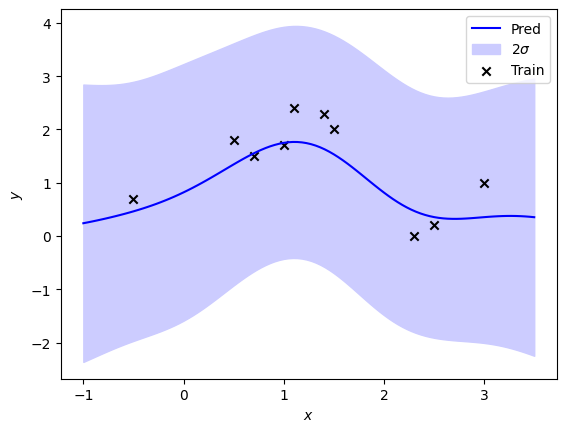

In [8]:
# 初期パラメータでのガウス過程回帰
mygpr = MyGPR_opt(xtrain, ytrain, xx, "rbf", params)
ypr, spr = mygpr.gpr(params)
mygpr.plot_gpr()

Optimization terminated successfully.
         Current function value: 2.509299
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
[1.524499165210284, 0.6892853493929163, 0.06701318345815824]
-2.5092991676957954


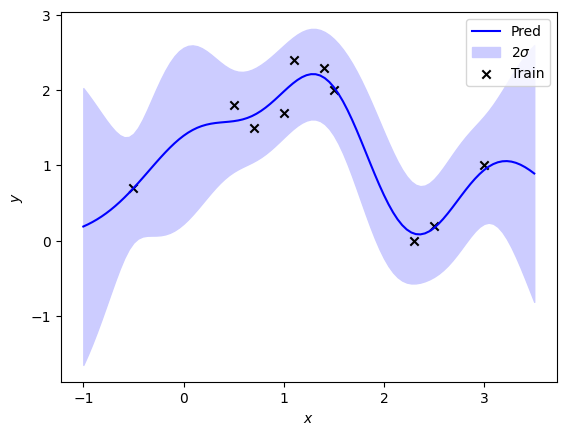

In [9]:
# BFGSによるパラメータ最適化
mygpr_bfgs = MyGPR_opt(xtrain, ytrain, xx, "rbf", params)
mygpr_bfgs.optimize_bfgs()
print([np.exp(p) for p in mygpr_bfgs.params_opt])
print(-mygpr_bfgs.logL(mygpr_bfgs.params_opt))
mygpr_bfgs.plot_gpr()

converged - relative reduction in gradient
[1.5248982557386839, 0.6891566077975273, 0.06698127933212211]
-2.509299674869137


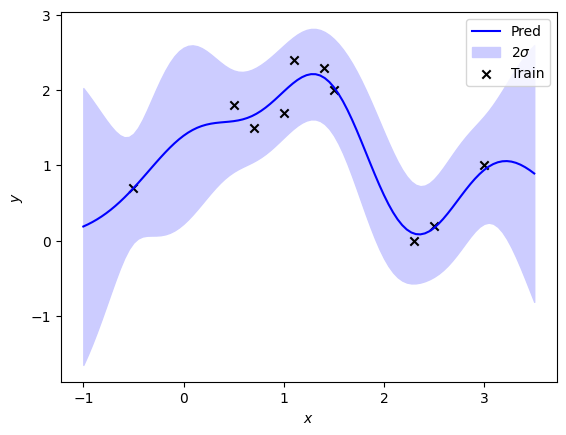

In [10]:
mygpr_scg = MyGPR_opt(xtrain, ytrain, xx, "rbf", params)
params_scg_opt = mygpr_scg.optimize_scg()
print([np.exp(p) for p in mygpr_scg.params_opt])
print(-mygpr_scg.logL(mygpr_scg.params_opt))
mygpr_scg.plot_gpr()

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOLRUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   5.914D-05   2.509D+00

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

[1.524496721137318, 0.6892791659456008, 0.06701295905055558]
-2.5092991679615846


 This problem is unconstrained.


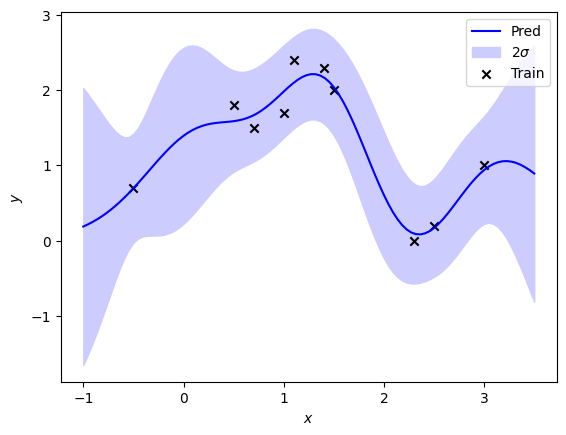

In [11]:
mygpr_l_bfgs_b = MyGPR_opt(xtrain, ytrain, xx, "rbf", params)
params_l_bfgs_b_opt = mygpr_l_bfgs_b.optimize_l_bfgs_b()
print([np.exp(p) for p in mygpr_l_bfgs_b.params_opt])
print(-mygpr_l_bfgs_b.logL(mygpr_l_bfgs_b.params_opt))
mygpr_l_bfgs_b.plot_gpr()

### ハイパーパラメータに対する尤度関数の値の描画

In [12]:
data_small = np.loadtxt('./../data/chap3/gpr.dat')[:5]
xtrain, ytrain = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
xx = np.linspace(-1, 3.5, 100).reshape(-1, 1)

In [13]:
class MyGPR_Loglik(MyGPR):
    def __init__(self, xtrain, ytrain, xx, kernel, params_init):
          super().__init__(xtrain, ytrain, xx, kernel, params_init)

    def logL(self):
        K = self.kernel_matrix(self.params_init)
        K_inv = np.linalg.inv(K)
        loglik = - np.log(np.abs(np.linalg.det(K))) - (self.ytrain.T @ K_inv @ self.ytrain)[0,0]
        return loglik

def get_logL(tau, params_grid, xtrain=xtrain, ytrain=ytrain, xx=xx, kernel="rbf"):
    l = len(params_grid)
    res = np.zeros(l)
    for i in range(l):
        params = np.append(tau, params_grid[i])
        logL = MyGPR_Loglik(xtrain=xtrain, ytrain=ytrain, xx=xx, kernel=kernel, params_init=params).logL()
        res[i] = logL
    return res

In [14]:
n_points = 100
t = 1 # tau
ss = np.linspace(-3, 12, n_points) # sigma
ee = np.linspace(-10, 3, n_points) # eta
SS, EE = np.meshgrid(ss, ee)
params_grid = np.hstack([SS.reshape(-1, 1), EE.reshape(-1, 1)])
logL = get_logL(t, params_grid)

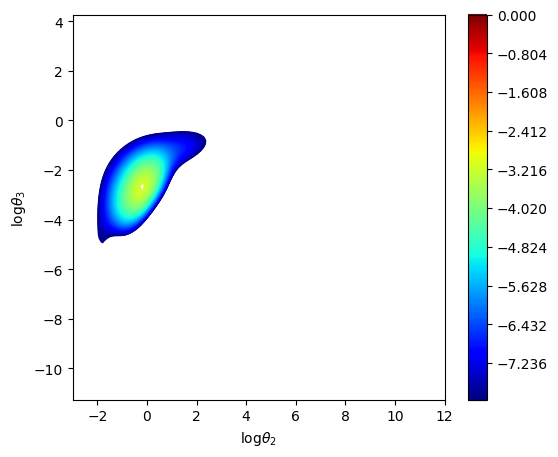

In [15]:
# 図示

zmin, zmax = -8, 0
fig = go.Figure(data=go.Surface(
    z=logL.reshape(n_points, n_points), 
    x=params_grid[:, 0].reshape(n_points, n_points), 
    y=params_grid[:, 1].reshape(n_points, n_points), 
    cmin = zmin,
    cmax = zmax,
    colorscale='jet'))
fig.update_layout(scene=dict(xaxis_title='log$\\theta_2$', yaxis_title='log$\\theta_3$', zaxis_title='log$L$',zaxis=dict(range=[zmin,zmax])), width=700, height=700)
fig.show()

plt.figure(figsize=(6, 5))
plt.contour(params_grid[:, 0].reshape(n_points, n_points), 
             params_grid[:, 1].reshape(n_points, n_points), 
             logL.reshape(n_points, n_points), 
             levels=np.linspace(zmin, zmax, 200), cmap='jet')
plt.colorbar()
plt.xlabel("log$\\theta_2$")
plt.ylabel("log$\\theta_3$")
plt.axis('equal')
plt.show()

### 100 m 走の世界記録のデータに対するガウス過程回帰

In [16]:
# import requests

# def fetch_records(url='https://en.wikipedia.org/wiki/Men%27s_100_metres_world_record_progression'):
#     headers = {
#         "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
#                       "AppleWebKit/537.36 (KHTML, like Gecko) "
#                       "Chrome/122.0.0.0 Safari/537.36"
#     }

#     resp = requests.get(url, headers=headers)
#     resp.raise_for_status()
#     html = resp.text

#     # HTML中のテーブルをすべて取得
#     tables = pd.read_html(html)

#     df = pd.DataFrame()

#     for idx, tbl in enumerate(tables):
#         if any("Duration of record" in str(col) for col in tbl.columns):
#             df = pd.concat([df, tables[idx]], ignore_index=True)

#     return df

# def save_to_csv(df, filename='./../data/chap3/100m_records.csv'):
#     df.to_csv(filename, index=False, encoding='utf-8-sig')
#     print(f"Saved CSV to {filename}")

In [17]:
# df = fetch_records()
# save_to_csv(df)

df = pd.read_csv('./../data/chap3/100m_records.csv')
print(df.head())

    Time Wind  Auto         Athlete    Nationality       Location of race  \
0  10.06  1.3   NaN       Bob Hayes  United States           Tokyo, Japan   
1  10.03  0.8   NaN       Jim Hines  United States        Sacramento, USA   
2  10.02  2.0   NaN  Charles Greene  United States    Mexico City, Mexico   
3   9.95  0.3   NaN       Jim Hines  United States    Mexico City, Mexico   
4   9.93  1.4   NaN    Calvin Smith  United States  Colorado Springs, USA   

               Date Notes[note 2]              Duration of record  
0  October 15, 1964           [5]    3 years, 8 months and 5 days  
1     June 20, 1968           [5]            3 months and 23 days  
2  October 13, 1968          A[5]                           1 day  
3  October 14, 1968      OR, A[2]  14 years, 8 months and 19 days  
4      July 3, 1983          A[2]    4 years, 1 month and 27 days  


     Time         Date
0   10.06  1964.786885
1   10.03  1968.467213
2   10.02  1968.781421
3    9.95  1968.784153
4    9.93  1983.501370
6    9.93  1987.660274
7    9.93  1988.625683
9    9.92  1988.729508
10   9.90  1991.449315
11   9.86  1991.646575
12   9.85  1994.509589
13   9.84  1996.568306
14   9.79  1999.454795
16   9.77  2005.449315
18   9.77  2006.441096
19   9.77  2006.627397
20   9.74  2007.687671
21   9.72  2008.412568
22   9.69  2008.622951
23   9.58  2009.621918


<Axes: xlabel='Date', ylabel='Time'>

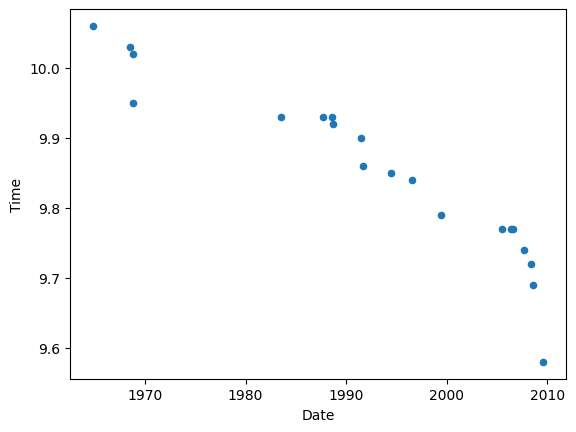

In [18]:
# データの前処理

def to_fractional_year(dates):
    year_start = dates.dt.to_period("Y").dt.start_time
    next_year_start = (dates.dt.to_period("Y") + 1).dt.start_time
    return dates.dt.year + (dates - year_start) / (next_year_start - year_start)

exclude_dates = pd.to_datetime(["2002-09-14", "2006-05-12"]) # 無効になった記録が記録された日
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Duration of record"] != "0 days"] # 記録のdurationが0日ものを削除
df = df[~df["Date"].isin(exclude_dates)] # 無効になった記録の削除
df["Date"] = to_fractional_year(df["Date"])
df = df[["Time", "Date"]]
print(df)

df.plot(x="Date", y="Time", kind="scatter")

In [19]:
data_100m = df[["Date","Time"]].to_numpy()
xtrain, ytrain = data_100m[:, 0].reshape(-1, 1), data_100m[:, 1].reshape(-1, 1)
xx = np.linspace(1964, 2020, 200).reshape(-1, 1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


 This problem is unconstrained.


CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   9.235D-06  -1.162D+01

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

[3.974733305116242, 12.858540655483706, 0.10772218526576412]
0.06018849495739464
11.624058462123454


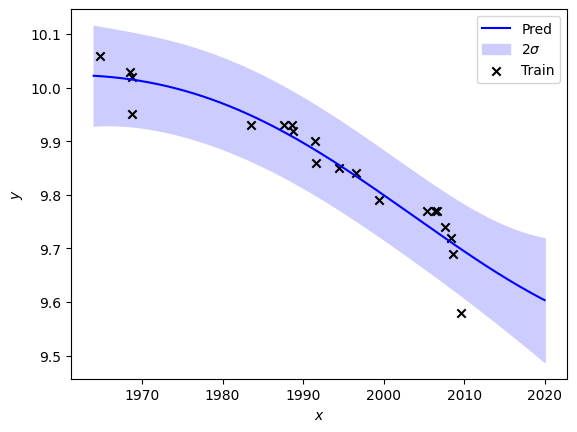

In [20]:
params_kg = np.array([0.0, 0.0, 0.0])
gpr_kg = MyGPR_opt(xtrain, ytrain, xx, "rbf", params_kg, xnormalize=True, ynormalize=True)
params_gpr_kg = gpr_kg.optimize_l_bfgs_b()
print([np.exp(p) for p in gpr_kg.params_opt])
print(np.exp(gpr_kg.params_opt[1])/np.std(xtrain)**2)
print(-gpr_kg.logL(gpr_kg.params_opt))
gpr_kg.plot_gpr()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


 This problem is unconstrained.


CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   3.294D-05  -9.862D+00

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

[1.6819457498563777, 0.4434189649764425, 0.06274328978862144]
9.861708986592387


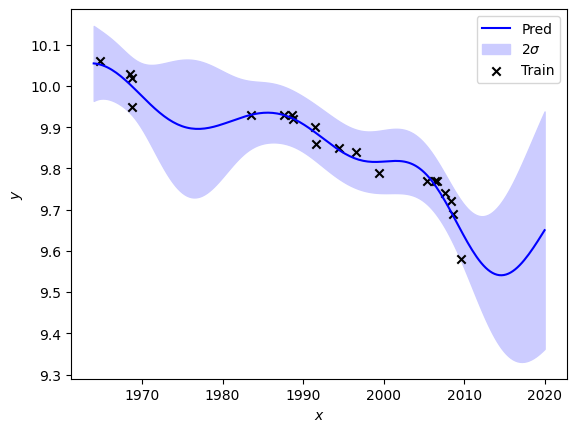

In [21]:
params_kg = np.array([0.0, -1.0, 0.0])
gpr_kg = MyGPR_opt(xtrain, ytrain, xx, "rbf", params_kg, xnormalize=True, ynormalize=True)
params_gpr_kg = gpr_kg.optimize_l_bfgs_b()
print([np.exp(p) for p in gpr_kg.params_opt])
print(-gpr_kg.logL(gpr_kg.params_opt))
gpr_kg.plot_gpr()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


 This problem is unconstrained.


CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations

[0.0954208663069869, 0.017621003734171945, 0.051550690176380906, 1.9016706580089e-09, 0.9220174590471661]
19.330883823976954
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     44      1     0     0   3.702D-05  -1.933D+01

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


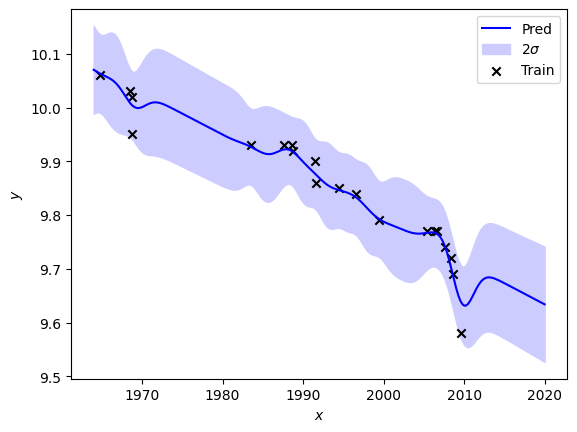

In [22]:
# 線形カーネル + RBFカーネル
params_ko1 = np.array([-5.0, 0.0, 0.0, 0.0, 1.0])
gpr_ko1 = MyGPR_opt(xtrain, ytrain, xx, "original1", params_ko1, xnormalize=True, ynormalize=True)
params_gpr_ko1 = gpr_ko1.optimize_l_bfgs_b()
print([np.exp(p) for p in gpr_ko1.params_opt])
print(-gpr_ko1.logL(gpr_ko1.params_opt))
gpr_ko1.plot_gpr()

### 外れ値がある場合のガウス過程回帰モデル

In [23]:
data = np.loadtxt('./../data/chap3/gpr-cauchy.dat')
xtrain, ytrain = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
xx = np.linspace(-5, 5, 200).reshape(-1, 1)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
           * * *


[2.326030557323768, 1.3450414222769456, 5.753386222639638]
Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     14      1     0     0   8.574D-05   1.186D+02

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
-118.64092951054782


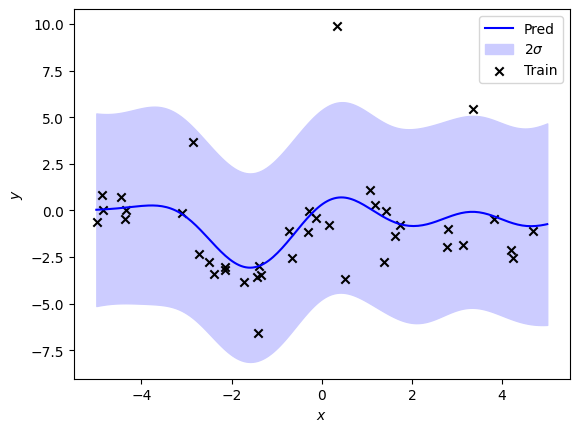

In [24]:
params_ol = np.array([0.0, 0.0, 0.0])
gpr_ol = MyGPR_opt(xtrain, ytrain, xx, "rbf", params_ol)
params_ol = gpr_ol.optimize_l_bfgs_b()
print([np.exp(p) for p in gpr_ol.params_opt])
print(-gpr_ol.logL(gpr_ol.params_opt))
gpr_ol.plot_gpr()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


 This problem is unconstrained.


CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   2.914D-05   1.130D+02

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

[7.051210812778473, 0.010024795948625093, 1.2047393183905188]
-112.99314705524105


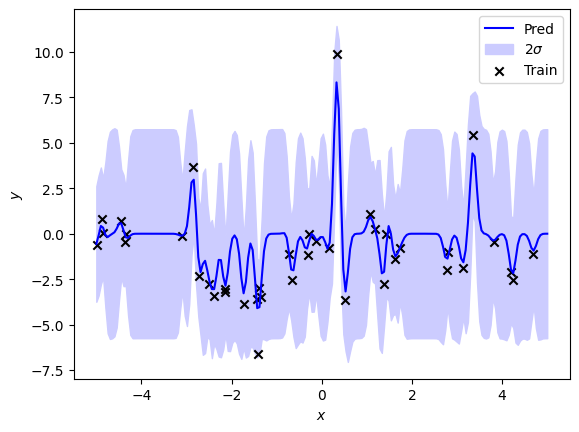

In [32]:
params_ol = np.array([5.0, -5.0, 0.0])
gpr_ol = MyGPR_opt(xtrain, ytrain, xx, "rbf", params_ol)
params_ol = gpr_ol.optimize_l_bfgs_b()
print([np.exp(p) for p in gpr_ol.params_opt])
print(-gpr_ol.logL(gpr_ol.params_opt))
gpr_ol.plot_gpr()